# AutoEncoder 

## Introduction

Autoencoders are a class of **unsupervised neural networks** that are trained to reconstruct their input. The network is composed of two main parts:  
- an **encoder** that compresses the input data into a lower-dimensional representation (also known as the *latent code* or *embedding*),  
- and a **decoder** that attempts to reconstruct the original input from this latent representation.

The objective of the autoencoder is to minimize the difference between the input and its reconstruction. This forces the network to **learn the most salient and informative features** of the input data, as only the most meaningful patterns can be retained through the limited capacity of the latent space (often called the **bottleneck**).

Autoencoders are particularly useful for:
- **Dimensionality reduction**
- **Denoising**
- **Anomaly detection**
- **Pretraining** for downstream tasks (feature extraction)

---

### How Do Autoencoders Differ from Classical Techniques like PCA?

While both PCA and autoencoders can be used for dimensionality reduction, they differ in several important aspects:

| Feature | PCA | Autoencoder |
|--------|-----|-------------|
| **Model type** | Linear | Non-linear (via neural networks) |
| **Feature extraction** | Orthogonal linear projections | Learned non-linear transformations |
| **Capacity** | Captures only global linear patterns | Can model complex and hierarchical features |
| **Training** | Closed-form solution | Requires gradient-based optimization |
| **Output** | Linearly decorrelated features | Non-linear embeddings, not necessarily orthogonal |

In fact, PCA is a special case of an autoencoder with:
- a single hidden layer,
- linear activations,
- and squared error loss.

Autoencoders, by using multiple non-linear layers and various regularizations, offer **much more flexible and powerful representations**, especially for real-world high-dimensional data.



### Comparison with Other Dimensionality Reduction Techniques (t-SNE, UMAP, Isomap)

Unlike PCA and autoencoders, **t-SNE**, **UMAP**, and **Isomap** are **non-parametric** manifold learning methods primarily used for **visualization** in 2D or 3D. Their differences from autoencoders include:

- They **do not learn a mapping function** from input to embedding; instead, they optimize embedding positions directly.
- They are not easily generalizable to new/unseen data points (i.e., no encoder).
- Autoencoders, in contrast, **learn a parametric mapping** and can generalize to new inputs, which makes them more suitable for tasks beyond visualization (e.g., generative modeling, feature extraction, transfer learning).

Thus, while t-SNE and UMAP are effective for low-dimensional plots, autoencoders are more versatile for downstream machine learning tasks.


## Mathematical Formulation of an Autoencoder

Let $x \in \mathbb{R}^n$ be an input vector (e.g., a flattened image).

An autoencoder consists of two parts:

- **Encoder:** Maps the input $x$ to a lower-dimensional hidden representation $z \in \mathbb{R}^m$, where $m < n$:

  $$
  z = f_{\theta}(x) = \sigma(W_e x + b_e)
  $$

- **Decoder:** Attempts to reconstruct the original input from the latent representation $z$:

  $$
  \hat{x} = g_{\phi}(z) = \sigma(W_d z + b_d)
  $$

Here:
- $\theta = \{W_e, b_e\}$ are the encoder parameters,
- $\phi = \{W_d, b_d\}$ are the decoder parameters,
- $\sigma$ is a non-linear activation function (e.g., ReLU, sigmoid).

### Loss Function

The goal is to minimize the reconstruction loss between the input $x$ and the output $\hat{x}$.

#### 1. Mean Squared Error (MSE):

$$
\mathcal{L}(x, \hat{x}) = \|x - \hat{x}\|^2 = \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
$$

Used for real-valued inputs.

#### 2. Binary Cross-Entropy (BCE):

$$
\mathcal{L}(x, \hat{x}) = -\sum_{i=1}^{n} \left[ x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right]
$$

Used when $x_i \in [0, 1]$, such as with normalized grayscale images.
#### Intuition Example: Effect of Prediction on BCE Loss


| True Value $x_i$ | Predicted $\hat{x}_i$ | Contribution to Loss      |
|------------------|------------------------|----------------------------|
| 1                | 0.99                   | $\approx 0.01005$ (good)  |
| 1                | 0.01                   | $\approx 4.60517$ (bad)   |
| 0                | 0.01                   | $\approx 0.01005$ (good)  |
| 0                | 0.99                   | $\approx 4.60517$ (bad)   |
|                  |                        | **Total: $\approx 9.2304$** |
### Training Objective

Minimize the average reconstruction loss over all training samples:

$$
\min_{\theta, \phi} \ \frac{1}{N} \sum_{j=1}^{N} \mathcal{L}(x^{(j)}, \hat{x}^{(j)})
$$

Where:
- $N$ is the number of training samples,
- $x^{(j)}$ is the $j$-th input sample,
- $\hat{x}^{(j)} = g_\phi(f_\theta(x^{(j)}))$ is the reconstruction.

### Optional Regularization

To improve generalization, regularization terms can be added:

- **L2 weight decay:**

  $$
  \mathcal{L}_{\text{total}} = \mathcal{L}(x, \hat{x}) + \lambda \left( \|W_e\|_2^2 + \|W_d\|_2^2 \right)
  $$

- **Sparsity penalty:** Encourages sparse activations in the latent space.


In [4]:
#pip install torch==2.4.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cpu
#pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
#pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
#pip install torch-geometric


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms 
#transforms: Converts images to PyTorch tensors.
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32):
        # Input dimension = 784: 28×28 grayscale image flattened into a 1D vector. 
        #Encoding dimension = 32: Compresses the 784 input values into just 32 values (features).
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(        # Reduces dimensionality: 784 → 32 and Uses a linear layer followed by ReLU activation.
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(        # Reconstructs input: 32 → 784 ,
                                             # Uses a linear layer followed by a sigmoid activation (to keep outputs in [0,1] range, 
                                             # matching the input pixel normalization).
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):                   # Passes input through encoder, then decoder, and returns the reconstruction.
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Load dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True) # shuffle=True for training to help generalization.
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

# Model, Loss, Optimizer
# model: Instantiates the autoencoder.
# criterion: Uses Mean Squared Error (MSE) as reconstruction loss (difference between input and output).
# optimizer: Uses Adam optimizer with learning rate 0.001.

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training:
# For 20 epochs (training iterations):
# Load a batch of images (imgs).
# Flatten each 28×28 image into a vector of size 784.
# Pass images through the autoencoder.
# Compute reconstruction loss between imgs and outputs.
# Backpropagate and update model weights.

for epoch in range(20):
    for imgs, _ in train_loader:
        imgs = imgs.view(imgs.size(0), -1)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/20], Loss: {loss.item():.4f}")



Epoch [1/20], Loss: 0.0519
Epoch [2/20], Loss: 0.0383
Epoch [3/20], Loss: 0.0313
Epoch [4/20], Loss: 0.0256
Epoch [5/20], Loss: 0.0239
Epoch [6/20], Loss: 0.0198
Epoch [7/20], Loss: 0.0185
Epoch [8/20], Loss: 0.0197
Epoch [9/20], Loss: 0.0185
Epoch [10/20], Loss: 0.0180
Epoch [11/20], Loss: 0.0176
Epoch [12/20], Loss: 0.0200
Epoch [13/20], Loss: 0.0165
Epoch [14/20], Loss: 0.0162
Epoch [15/20], Loss: 0.0179
Epoch [16/20], Loss: 0.0181
Epoch [17/20], Loss: 0.0168
Epoch [18/20], Loss: 0.0175
Epoch [19/20], Loss: 0.0179
Epoch [20/20], Loss: 0.0173


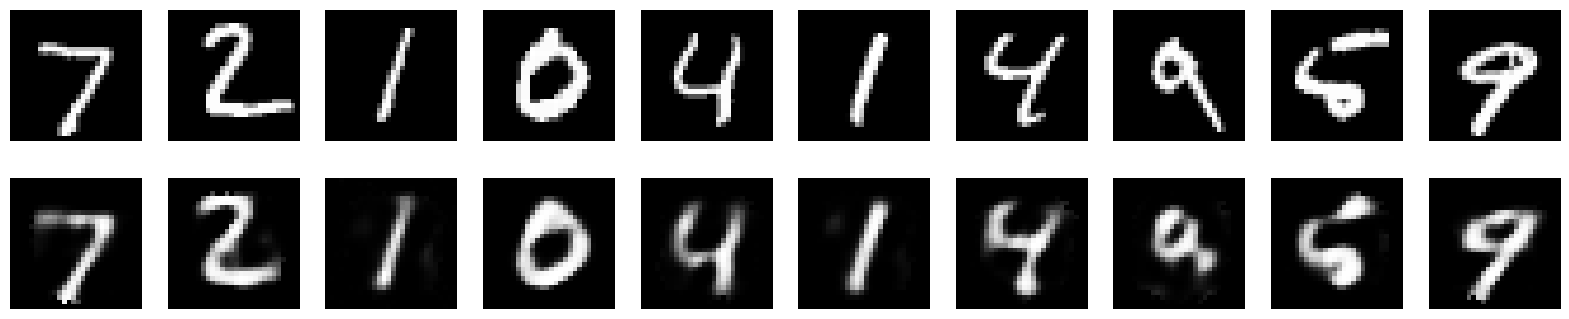

In [50]:
# Visualization
import numpy as np
model.eval() #Switches the model to evaluation mode. This disables layers like Dropout or BatchNorm that behave differently during training vs. inference.

with torch.no_grad():
    # torch.no_grad: Prevents PyTorch from tracking operations for gradient computation. Reduces memory usage and speeds up computation.
    # Useful because we’re not training — just evaluating.
    
    imgs, _ = next(iter(test_loader))  # Gets a single batch from the test set.
    imgs = imgs.view(imgs.size(0), -1) # Flattens each image from 28×28 to 784-dim vector.
    outputs = model(imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28).numpy(), cmap='gray') # Original images
        ax.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].reshape(28, 28).numpy(), cmap='gray') # Reconstructed images
        ax.axis('off')
    plt.show()

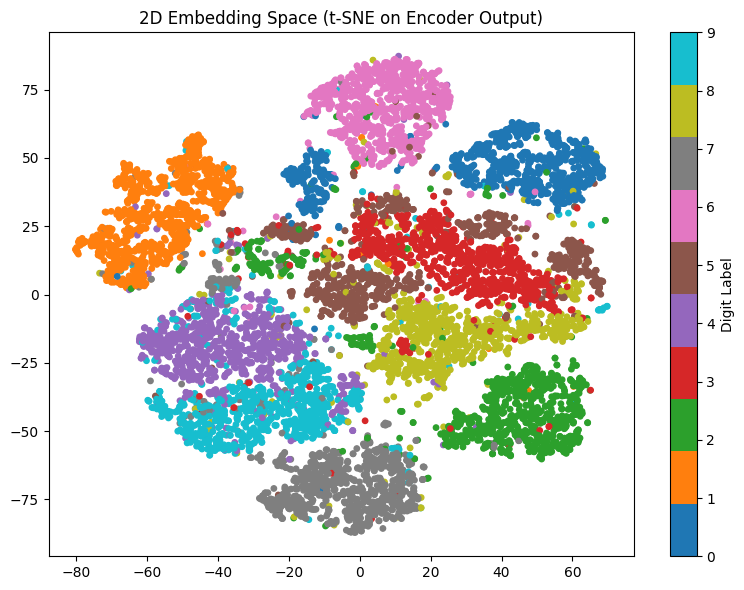

In [51]:
from sklearn.manifold import TSNE

model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.view(imgs.size(0), -1)
        z = model.encoder(imgs)
        embeddings.append(z)
        labels.append(lbls)

# Stack all batches
embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
z_2d = tsne.fit_transform(embeddings)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', s=15)
plt.colorbar(scatter, label="Digit Label")
plt.title("2D Embedding Space (t-SNE on Encoder Output)")
plt.tight_layout()
plt.show()


In [52]:
# Assume the model is already trained and ready

# Set the model to evaluation mode
model.eval()

# Get one batch from the test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Prepare (flatten) the images
images_flat = images.view(images.size(0), -1)

# Get the embeddings from the encoder
with torch.no_grad():
    embeddings = model.encoder(images_flat)

# Display the first 10 embeddings
print("Embedding for first 10 test images:")
print(embeddings[:10])


Embedding for first 10 test images:
tensor([[10.0645,  7.0116,  7.3378,  0.0000,  0.0000,  1.0820,  0.0000, 11.0301,
          1.8621,  6.5599, 16.3086,  6.1684,  5.6763, 11.9695,  4.9848,  0.0000,
          0.0000, 15.5984, 14.1261,  0.0000, 10.4217,  0.0000,  0.0000,  0.0000,
          3.6606,  0.0000,  0.0000,  3.3472,  8.9203, 12.1496,  6.7739,  5.9821],
        [ 6.8650, 14.0952,  1.7086,  0.0000,  0.0000, 15.6798,  0.0000,  8.3858,
         12.4977,  7.1092,  4.7880, 20.6311, 14.3042,  9.9900,  8.9005,  0.0000,
          0.0000, 10.7787,  8.7382,  0.0000,  4.8349,  0.0000,  0.0000,  0.0000,
          9.2421,  0.0000,  0.0000, 12.5975, 15.5176, 11.6455,  9.2759,  5.2672],
        [ 2.8533,  3.4799,  8.7332,  0.0000,  0.0000,  1.1526,  0.0000,  2.0977,
          5.4279,  5.3094,  1.3333,  4.8491,  3.4279,  2.7164,  1.8434,  0.0000,
          0.0000,  2.8562,  3.8884,  0.0000,  4.2940,  0.0000,  0.0000,  0.0000,
          5.8955,  0.0000,  0.0000,  7.3616,  8.0028,  8.5125,  5.8846,

## Denoising Autoencoder (DAE)

### Introduction

A **Denoising Autoencoder (DAE)** is an extension of the traditional autoencoder. It is trained to reconstruct the **original clean input** from a **noisy version** of that input. By doing so, it learns **robust and invariant feature representations**, rather than simply learning to replicate the input.

This is useful in scenarios where input data may be **corrupted by noise**, and we still want to extract reliable features for downstream tasks.

---

### Mathematical Formulation

Let $x \in \mathbb{R}^n$ be a clean input vector, and let $\tilde{x} \in \mathbb{R}^n$ be a **noisy version** of $x$, sampled from a **corruption distribution** $q(\tilde{x} \mid x)$. The goal of the DAE is to recover $x$ from $\tilde{x}$.

---

#### **Encoder**  
Maps the corrupted input $\tilde{x}$ to a latent representation $z \in \mathbb{R}^m$:

$$
z = f_{\theta}(\tilde{x}) = \sigma(W_e \tilde{x} + b_e)
$$

---

#### **Decoder**  
Reconstructs the clean input $x$ from the latent representation $z$:

$$
\hat{x} = g_{\phi}(z) = \sigma(W_d z + b_d)
$$

---

#### **Loss Function**

The DAE is trained to minimize the **expected reconstruction error** over the noise distribution:

$$
\mathcal{L}_{\text{DAE}}(x, \hat{x}) = \mathbb{E}_{\tilde{x} \sim q(\tilde{x}|x)} \left[ \|x - g_{\phi}(f_{\theta}(\tilde{x}))\|^2 \right]
$$

Alternatively, for binary inputs (e.g., binarized images), **Binary Cross-Entropy (BCE)** loss is often used:

$$
\mathcal{L}_{\text{DAE}}(x, \hat{x}) = -\sum_{i=1}^{n} \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
$$

---

### Key Idea

The corruption process $q(\tilde{x} \mid x)$ could include:
- **Additive Gaussian noise**
- **Salt-and-pepper noise**
- **Random masking (e.g., setting a fraction of inputs to 0)**

By learning to recover the original $x$ from $\tilde{x}$, the DAE generalizes better and avoids simply memorizing training data.

---

### Implementation with PyTorch



DAE Epoch [1/20], Loss: 0.0485
DAE Epoch [2/20], Loss: 0.0344
DAE Epoch [3/20], Loss: 0.0309
DAE Epoch [4/20], Loss: 0.0265
DAE Epoch [5/20], Loss: 0.0242
DAE Epoch [6/20], Loss: 0.0238
DAE Epoch [7/20], Loss: 0.0233
DAE Epoch [8/20], Loss: 0.0233
DAE Epoch [9/20], Loss: 0.0249
DAE Epoch [10/20], Loss: 0.0218
DAE Epoch [11/20], Loss: 0.0235
DAE Epoch [12/20], Loss: 0.0223
DAE Epoch [13/20], Loss: 0.0227
DAE Epoch [14/20], Loss: 0.0252
DAE Epoch [15/20], Loss: 0.0245
DAE Epoch [16/20], Loss: 0.0238
DAE Epoch [17/20], Loss: 0.0212
DAE Epoch [18/20], Loss: 0.0216
DAE Epoch [19/20], Loss: 0.0233
DAE Epoch [20/20], Loss: 0.0223


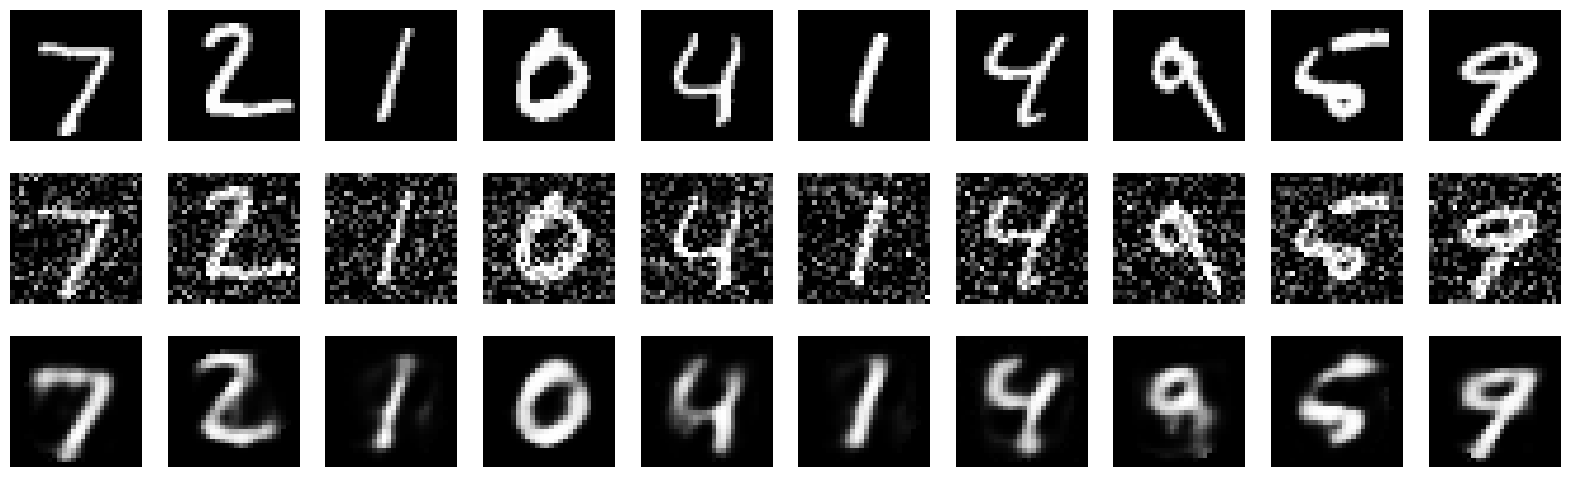

In [54]:
# Define Denoising Autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Add noise to input
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

# Model, optimizer
dae_model = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    for imgs, _ in train_loader:
        imgs = imgs.view(imgs.size(0), -1)
        noisy_imgs = add_noise(imgs)
        outputs = dae_model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"DAE Epoch [{epoch+1}/20], Loss: {loss.item():.4f}")

# Visualization
dae_model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.view(imgs.size(0), -1)
    noisy_imgs = add_noise(imgs)
    outputs = dae_model(noisy_imgs)

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28).numpy(), cmap='gray')
        ax.axis('off')

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_imgs[i].reshape(28, 28).numpy(), cmap='gray')
        ax.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(outputs[i].reshape(28, 28).numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

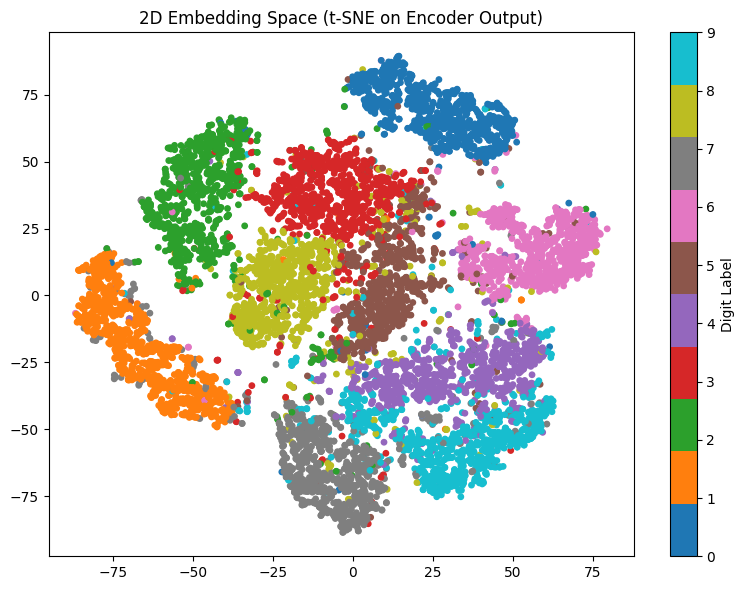

In [55]:
from sklearn.manifold import TSNE

dae_model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.view(imgs.size(0), -1)
        z = dae_model.encoder(imgs)
        embeddings.append(z)
        labels.append(lbls)

# Stack all batches
embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
z_2d = tsne.fit_transform(embeddings)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', s=15)
plt.colorbar(scatter, label="Digit Label")
plt.title("2D Embedding Space (t-SNE on Encoder Output)")
plt.tight_layout()
plt.show()


In [ ]:
# Assume the model is already trained and ready

# Set the model to evaluation mode
model.eval()

# Get one batch from the test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Prepare (flatten) the images
images_flat = images.view(images.size(0), -1)

# Get the embeddings from the encoder
with torch.no_grad():
    embeddings = model.encoder(images_flat)

# Display the first 10 embeddings
print("Embedding for first 10 test images:")
print(embeddings[:10])


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# dimension redunction for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings[:100].numpy())  # فقط 100 تصویر اول

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels[:100], cmap='tab10')
plt.colorbar()
plt.title("2D Embedding of Test Images")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


## Variational Autoencoder (VAE)

### Introduction

A **Variational Autoencoder (VAE)** is a generative model that learns to encode input data into a **distribution over a latent space**, and then decode from this latent space to reconstruct the input.

Unlike standard autoencoders that map inputs to fixed latent vectors, VAEs map inputs to **probability distributions**, allowing:
- Smooth interpolation
- Meaningful latent representations
- Probabilistic generation of new samples

---

### Generative Process

Let:
- $x \in \mathbb{R}^D$ be the observed data (e.g., an image),
- $z \in \mathbb{R}^d$ be the latent variable (hidden representation).

The VAE assumes the following **generative process**:

1. **Prior distribution over latent variables**:
   $$
   p(z) = \mathcal{N}(z \mid 0, I)
   $$
   - This is the **prior**: a simple standard normal distribution.
   - It reflects our assumption about $z$ before seeing any data.

2. **Likelihood (decoder) – probability of data given latent variable**:
   $$
   p_{\theta}(x|z)
   $$
   - This is the **likelihood**, or **decoder**.
   - It models the probability of observing $x$ given the latent variable $z$.
   - Typically parameterized by a neural network with parameters $\theta$.
     - For binary data: $p_{\theta}(x|z)$ is a Bernoulli distribution.
     - For continuous data: $p_{\theta}(x|z)$ is a Gaussian.

Thus, the **joint distribution** is:
$$
p_{\theta}(x, z) = p(z) \cdot p_{\theta}(x|z)
$$

---

### Inference Model (Encoder)

The **posterior distribution** $p(z|x)$ is typically **intractable**, so we approximate it with a variational distribution:

$$
q_{\phi}(z|x) = \mathcal{N}(z \mid \mu(x), \text{diag}(\sigma^2(x)))
$$

- This is the **variational posterior** or **encoder**.
- It models the distribution over latent variables $z$ given input $x$.
- The mean $\mu(x)$ and variance $\sigma^2(x)$ are outputs of a neural network with parameters $\phi$.

---

### Reparameterization Trick

To allow backpropagation through sampling, we use the **reparameterization trick**:

$$
z = \mu(x) + \sigma(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling process differentiable, enabling end-to-end training of both encoder and decoder.

---

### Decoder (Generative Network)

Given a latent variable $z$, the decoder predicts the reconstruction $\hat{x}$:

$$
\hat{x} = g_{\theta}(z)
$$

This maps $z$ to the parameters of the distribution $p_{\theta}(x|z)$:
- For binary $x$: outputs probabilities for each pixel (Bernoulli)
- For continuous $x$: outputs mean and variance (Gaussian)

---

### Loss Function: Evidence Lower Bound (ELBO)

We aim to **maximize the marginal likelihood** $p(x)$:

$$
p(x) = \int p_{\theta}(x|z) p(z) \, dz
$$

But this is intractable due to the integral. So we maximize the **Evidence Lower Bound (ELBO)** instead:

$$
\mathcal{L}_{\text{ELBO}}(x) = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - \text{KL}(q_{\phi}(z|x) \| p(z))
$$

#### Breakdown:

1. **Reconstruction Term** (negative expected log-likelihood):
   $$
   \mathcal{L}_{\text{recon}} = -\mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)]
   $$
   - Measures how well the model reconstructs $x$ from $z$.
   - For binary data: binary cross-entropy loss.
   - For continuous data: typically mean squared error.

2. **KL Divergence Term**:
   $$
   \text{KL}(q_{\phi}(z|x) \| p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \sigma_i^2 + \mu_i^2 - \log \sigma_i^2 - 1 \right)
   $$
   - Encourages $q_{\phi}(z|x)$ to stay close to the prior $p(z)$.
   - Acts as a regularizer.

#### Total VAE Loss:

To train the model, we **minimize** the negative ELBO:

$$
\mathcal{L}_{\text{VAE}}(x) = \mathcal{L}_{\text{recon}} + \text{KL}(q_{\phi}(z|x) \| p(z))
$$

---

### Probabilities Summary

| Symbol | Meaning |
|--------|---------|
| $p(z)$ | Prior over latent variables: $\mathcal{N}(0, I)$ |
| $p_{\theta}(x|z)$ | Likelihood: probability of data given latent code (decoder) |
| $p(x)$ | Marginal likelihood: true probability of data (intractable) |
| $q_{\phi}(z|x)$ | Variational posterior: approximate inference (encoder) |
| $\hat{x}$ | Reconstructed version of $x$ decoded from $z$ |

---

### Key Insights

- **KL divergence** regularizes the encoder to match the prior distribution.
- The **reconstruction term** ensures high-fidelity output.
- The **reparameterization trick** allows gradient-based learning despite sampling.

---

### Benefits of VAEs

- **Generative power**: Can generate new, coherent samples
- **Structured latent space**: Smooth, interpretable embeddings
- **Uncertainty modeling**: Each input maps to a distribution, not a point

---

### Summary Table

| Component            | Standard Autoencoder         | Variational Autoencoder            |
|---------------------|------------------------------|------------------------------------|
| Latent Representation | Fixed deterministic vector   | Distribution (mean & variance)     |
| Output               | Deterministic reconstruction | Sampled from a generative model    |
| Loss Function        | Reconstruction error only     | Reconstruction + KL divergence     |
| Sampling Capability  | Not generative                | Generative via latent sampling     |


In [ ]:

### Implementation with PyTorch
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # log-variance
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(20):
    for imgs, _ in train_loader:
        imgs = imgs.view(imgs.size(0), -1)
        recon_batch, mu, logvar = vae(imgs)
        loss = vae_loss_function(recon_batch, imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"VAE Epoch [{epoch+1}/20], Loss: {loss.item():.4f}")

VAE Epoch [1/20], Loss: 13633.1777
VAE Epoch [2/20], Loss: 12238.8799
VAE Epoch [3/20], Loss: 10848.4971
VAE Epoch [4/20], Loss: 10685.9229
VAE Epoch [5/20], Loss: 10699.0498
VAE Epoch [6/20], Loss: 10388.0898
VAE Epoch [7/20], Loss: 10284.7217
VAE Epoch [8/20], Loss: 10592.0371
VAE Epoch [9/20], Loss: 10648.1543
VAE Epoch [10/20], Loss: 10769.5879
VAE Epoch [11/20], Loss: 9880.6123
VAE Epoch [12/20], Loss: 10005.2109
VAE Epoch [13/20], Loss: 10222.7012
VAE Epoch [14/20], Loss: 10388.3867
VAE Epoch [15/20], Loss: 10772.9004


### Generating New Data with VAE

One of the key capabilities of a Variational Autoencoder (VAE) is its generative nature. After training the model, we can sample new points from the latent space and decode them into the data space to generate entirely new examples.

In this case, we demonstrate this by drawing random samples from a standard normal distribution in the latent space and passing them through the decoder. Since the VAE was trained on MNIST digits, the output will be synthetic handwritten digits that resemble the training data — even though they are not exact copies of any original input.

This process highlights how VAEs learn a continuous, structured latent representation of data that enables meaningful and smooth sampling for generation.


In [ ]:
# Generate new samples from the latent space
import matplotlib.pyplot as plt

vae.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Sample 10 random latent vectors from a standard normal distribution
    z = torch.randn(10, 20)  # latent_dim = 20
    generated = vae.decode(z)

    # Plot the generated images
    plt.figure(figsize=(15, 2))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generated[i].view(28, 28).cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Digits from VAE Latent Space')
    plt.show()


---
## Graph Autoencoder (GAE)

### Introduction

A **Graph Autoencoder (GAE)** is a type of neural network designed to learn low-dimensional representations of nodes in graph-structured data by following the encoder–decoder paradigm. The encoder maps the input node features and graph topology to a latent space, and the decoder attempts to reconstruct the graph structure—typically the adjacency matrix—from these embeddings.

GAEs are widely used in:

- **Link prediction** (inferring missing or future edges)
- **Node clustering** (grouping nodes by similarity in the latent space)
- **Graph compression and visualization**
- **Network denoising** (removing spurious or noisy edges)

### Key Considerations

When applying autoencoders to graphs:

- The model inputs and outputs are often based on the **adjacency matrix**.
- Graphs are **sparse**, so most node pairs do not share an edge. This makes reconstruction biased toward predicting zeros unless handled carefully.
- The **absence of an edge** doesn't always imply dissimilarity, so the loss function and sampling strategy must be thoughtfully designed.
- **Negative edge sampling** is usually employed to balance training between positive (existing) and negative (non-existing) edges.

Extensions of GAEs may incorporate:

- **First-order proximity** (direct neighbors)
- **Higher-order proximity** (shared neighbors or paths)
- **Node attributes** through feature-aware encoders (e.g., GCN, GAT)

---

### Mathematical Formulation

Let:

- $A \in \mathbb{R}^{n \times n}$ be the adjacency matrix of the graph  
- $X \in \mathbb{R}^{n \times d}$ be the node feature matrix

#### Encoder

A Graph Neural Network (e.g., GCN) encodes each node into a latent representation:

$$
Z = \text{GNN}(X, A)
$$

where $Z \in \mathbb{R}^{n \times h}$ is the matrix of node embeddings, with $h$ being the embedding dimension.

#### Decoder

The decoder reconstructs the adjacency matrix via the inner product of embeddings:

$$
\hat{A}_{ij} = \sigma(\mathbf{z}_i^\top \mathbf{z}_j)
$$

where $\sigma$ is the sigmoid function and $\hat{A}$ is the reconstructed adjacency matrix.

#### Loss Function

**Naive (Frobenius norm / squared reconstruction loss):**

$$
\mathcal{L}_{\text{GAE}} = \| A - \hat{A} \|_F^2
$$

- Works for small or dense graphs
- Inefficient for large or sparse graphs due to overwhelming number of zeros

**Binary cross-entropy with negative sampling:**

$$
\mathcal{L}_{\text{BCE}} = -\sum_{(i,j) \in \mathcal{E}} \log \hat{A}_{ij} - \sum_{(i,j) \in \mathcal{E}^-} \log (1 - \hat{A}_{ij})
$$

- $\mathcal{E}$: set of real (positive) edges
- $\mathcal{E}^-$: set of sampled non-edges (negative edges)
- Typically, $|\mathcal{E}^-| \approx |\mathcal{E}|$ to balance the loss

---

### Negative Edge Sampling

Since most node pairs are not connected, it is inefficient and unnecessary to compute the loss over all non-edges. Instead, we sample a subset:

```python
from torch_geometric.utils import negative_sampling

neg_edge_index = negative_sampling(
    edge_index=edge_index,     # positive edges
    num_nodes=data.num_nodes,  # total number of nodes
    num_neg_samples=edge_index.size(1)  # equal number of negatives
)


Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Using device: cpu
Starting training...
Epoch 020, Total Loss: 34899.7422, Recon Loss: 0.8776, Sparse Loss: 34898.8633, Val AUC: 0.6282, Val AP: 0.6671
Epoch 040, Total Loss: 33884.4180, Recon Loss: 0.6962, Sparse Loss: 33883.7227, Val AUC: 0.6477, Val AP: 0.6824
Epoch 060, Total Loss: 33096.0469, Recon Loss: 0.6070, Sparse Loss: 33095.4414, Val AUC: 0.7242, Val AP: 0.7443
Epoch 080, Total Loss: 32338.7266, Recon Loss: 0.5046, Sparse Loss: 32338.2227, Val AUC: 0.8476, Val AP: 0.8681
Epoch 100, Total Loss: 31176.4824, Recon Loss: 0.4781, Sparse Loss: 31176.0039, Val AUC: 0.8243, Val AP: 0.8434
Epoch 120, Total Loss: 30384.3828, Recon Loss: 0.4398, Sparse Loss: 30383.9434, Val AUC: 0.8199, Val AP: 0.8296
Epoch 140, Total Loss: 29291.9238, Recon Loss: 0.3999, Sparse Loss: 29291.5234, Val AUC: 0.8114, Val AP: 0.8246
Epoch 160, Total Loss: 27785.5078, Recon Loss: 0.3840, Sparse Loss: 27785.1230, Val AUC: 0.

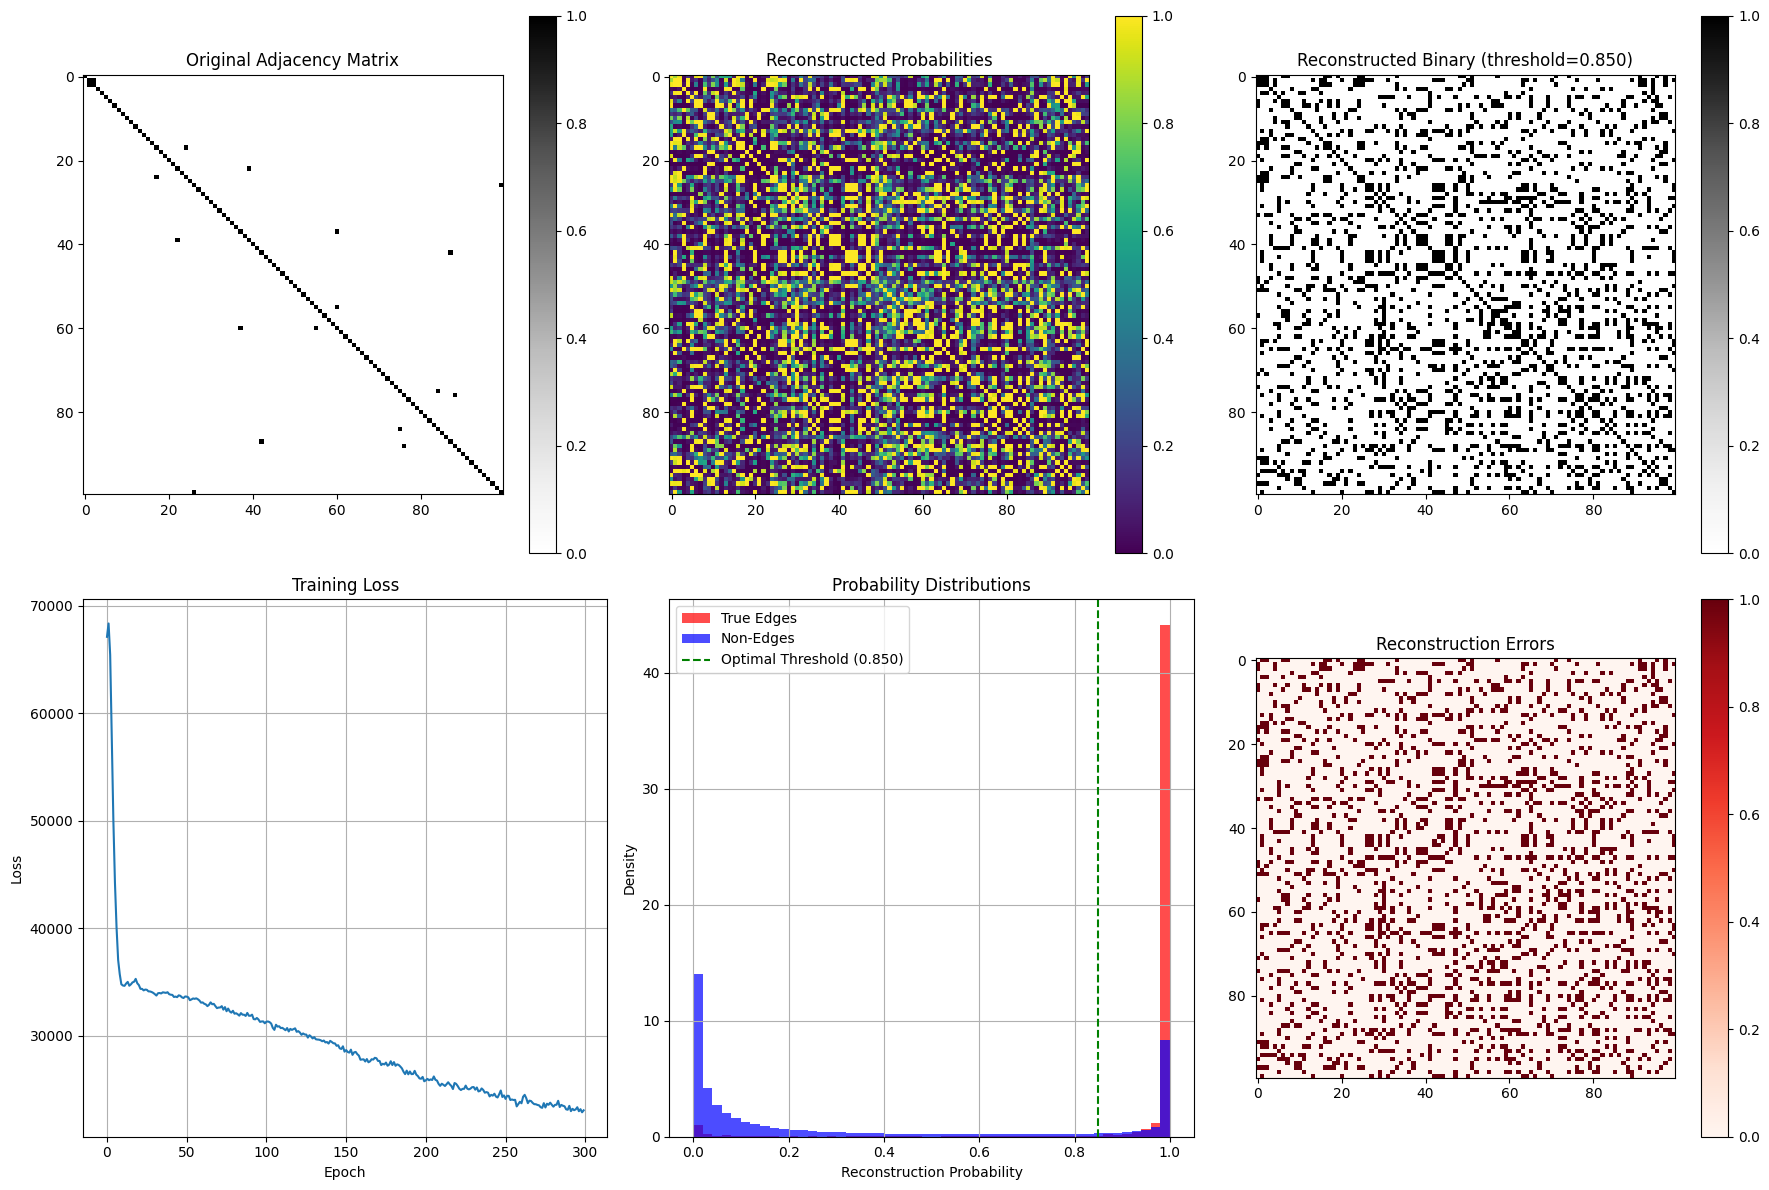

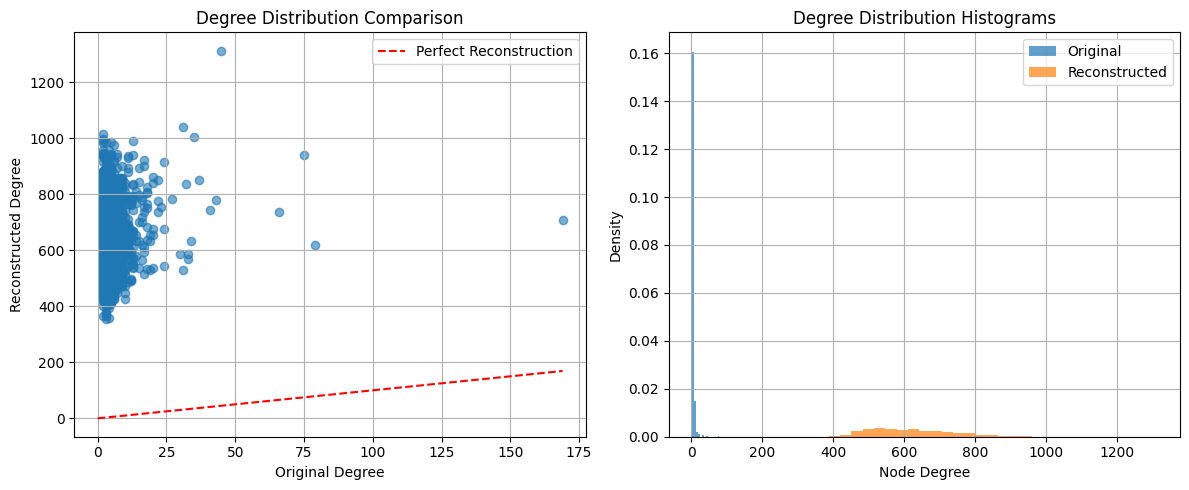

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit
from torch_geometric.utils import negative_sampling, add_self_loops, to_dense_adj
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

# Load and preprocess the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")

# Remove self-loops and add them back controlled
data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)

# Use a more conservative split
transform = RandomLinkSplit(is_undirected=True, split_labels=True, 
                           add_negative_train_samples=True, neg_sampling_ratio=1.0,
                           num_val=0.1, num_test=0.1)
train_data, val_data, test_data = transform(data)

class SparseGraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        
        # Encoder layers with aggressive dropout
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        
        # Batch normalization
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Additional layers for better representation
        self.fc = torch.nn.Linear(out_channels, out_channels)
        
    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        
        # Final transformation
        x = self.fc(x)
        
        return x

class SparseGraphAutoEncoder(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        
    def forward(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def decode(self, z, edge_index):
        # Simple inner product decoder with temperature scaling
        temperature = 10.0  # Higher temperature for sharper decisions
        scores = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1) / temperature
        return torch.sigmoid(scores)
    
    def decode_all(self, z):
        # For adjacency matrix reconstruction with sparsity encouragement
        temperature = 10.0
        logits = torch.matmul(z, z.T) / temperature
        return torch.sigmoid(logits)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters - reduced complexity
hidden_channels = 64
out_channels = 32
dropout = 0.6

# Initialize model
encoder = SparseGraphEncoder(dataset.num_features, hidden_channels, out_channels, dropout)
model = SparseGraphAutoEncoder(encoder).to(device)

# More aggressive optimizer settings
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.8, patience=20, verbose=True)

# Move data to device
x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

def compute_sparsity_loss(adj_pred, original_adj, lambda_sparse=0.1):
    """Encourage sparsity in reconstructed adjacency matrix"""
    # L1 penalty on predicted adjacency matrix
    sparsity_loss = lambda_sparse * torch.mean(adj_pred)
    
    # Additional penalty for predicting too many edges
    num_predicted_edges = torch.sum(adj_pred > 0.5)
    num_true_edges = torch.sum(original_adj)
    edge_count_penalty = 0.01 * F.relu(num_predicted_edges - 2 * num_true_edges)
    
    return sparsity_loss + edge_count_penalty

def train():
    model.train()
    optimizer.zero_grad()
    
    # Encode
    z = model(x, edge_index)
    
    # Positive and negative edges
    pos_edge = train_data.pos_edge_label_index.to(device)
    neg_edge = train_data.neg_edge_label_index.to(device)
    
    # Decode
    pos_score = model.decode(z, pos_edge)
    neg_score = model.decode(z, neg_edge)
    
    # Enhanced loss function
    pos_loss = F.binary_cross_entropy(pos_score, torch.ones_like(pos_score), reduction='mean')
    neg_loss = F.binary_cross_entropy(neg_score, torch.zeros_like(neg_score), reduction='mean')
    
    # Weighted loss to handle imbalance
    recon_loss = 2.0 * pos_loss + neg_loss
    
    # Add sparsity regularization
    adj_pred = model.decode_all(z)
    original_adj = torch.zeros((data.num_nodes, data.num_nodes), device=device)
    original_adj[data.edge_index[0], data.edge_index[1]] = 1.0
    
    sparse_loss = compute_sparsity_loss(adj_pred, original_adj, lambda_sparse=0.01)
    
    # KL divergence between predicted and true degree distribution
    pred_degrees = torch.sum(adj_pred, dim=1)
    true_degrees = torch.sum(original_adj, dim=1)
    kl_loss = 0.001 * F.kl_div(F.log_softmax(pred_degrees, dim=0), 
                               F.softmax(true_degrees, dim=0), reduction='batchmean')
    
    total_loss = recon_loss + sparse_loss + kl_loss
    
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    
    optimizer.step()
    return total_loss.item(), recon_loss.item(), sparse_loss.item()

def test(data_split):
    model.eval()
    with torch.no_grad():
        z = model(x, edge_index)
        
        pos_edge = data_split.pos_edge_label_index.to(device)
        neg_edge = data_split.neg_edge_label_index.to(device)
        
        pos_score = model.decode(z, pos_edge)
        neg_score = model.decode(z, neg_edge)
        
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = torch.cat([torch.ones(pos_score.size(0)), 
                           torch.zeros(neg_score.size(0))]).cpu().numpy()
        
        auc = roc_auc_score(labels, scores)
        ap = average_precision_score(labels, scores)
        
        return auc, ap

# Training loop with early stopping
print("Starting training...")
train_losses = []
val_aucs = []
best_val_auc = 0
patience_counter = 0
max_patience = 50

for epoch in range(1, 301):
    total_loss, recon_loss, sparse_loss = train()
    train_losses.append(total_loss)
    
    if epoch % 20 == 0:
        val_auc, val_ap = test(val_data)
        val_aucs.append(val_auc)
        
        print(f'Epoch {epoch:03d}, Total Loss: {total_loss:.4f}, '
              f'Recon Loss: {recon_loss:.4f}, Sparse Loss: {sparse_loss:.4f}, '
              f'Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')
        
        scheduler.step(total_loss)
        
        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= max_patience:
            print("Early stopping!")
            break

# Final test evaluation
test_auc, test_ap = test(test_data)
print(f'\nFinal Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

# ===== Improved Adjacency Matrix Reconstruction =====
print("\nReconstructing adjacency matrix...")
model.eval()
with torch.no_grad():
    z = model(x, edge_index)
    adj_reconstructed = model.decode_all(z)

# Convert original adjacency matrix to dense form
original_adj = torch.zeros((data.num_nodes, data.num_nodes), device=device)
original_adj[data.edge_index[0], data.edge_index[1]] = 1.0

# Find optimal threshold using validation set
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    adj_binary = (adj_reconstructed > threshold).float()
    
    # Calculate F1 score
    tp = (original_adj * adj_binary).sum().item()
    fp = ((1 - original_adj) * adj_binary).sum().item()
    fn = (original_adj * (1 - adj_binary)).sum().item()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}, Best F1: {best_f1:.4f}")

# Apply optimal threshold
adj_reconstructed_binary = (adj_reconstructed > best_threshold).float()

# Calculate comprehensive metrics
total_elements = original_adj.numel()
correct_predictions = (original_adj == adj_reconstructed_binary).sum().item()
accuracy = correct_predictions / total_elements

true_edges = original_adj.sum().item()
predicted_edges = adj_reconstructed_binary.sum().item()
true_positive = (original_adj * adj_reconstructed_binary).sum().item()

precision = true_positive / predicted_edges if predicted_edges > 0 else 0
recall = true_positive / true_edges if true_edges > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAdjacency Matrix Reconstruction Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"True edges: {int(true_edges)}, Predicted edges: {int(predicted_edges)}")

# Show sample comparisons
print(f"\nSample comparison (first 20x20):")
print("Original:")
print(original_adj[:20, :20].cpu().numpy().astype(int))
print(f"\nReconstructed (threshold={best_threshold:.3f}):")
print(adj_reconstructed_binary[:20, :20].cpu().numpy().astype(int))

# Advanced visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original adjacency matrix
im1 = axes[0, 0].imshow(original_adj[:100, :100].cpu().numpy(), cmap='Greys', interpolation='none')
axes[0, 0].set_title("Original Adjacency Matrix")
plt.colorbar(im1, ax=axes[0, 0])

# Reconstructed probabilities
im2 = axes[0, 1].imshow(adj_reconstructed[:100, :100].cpu().numpy(), cmap='viridis', 
                        interpolation='none', vmin=0, vmax=1)
axes[0, 1].set_title("Reconstructed Probabilities")
plt.colorbar(im2, ax=axes[0, 1])

# Reconstructed binary
im3 = axes[0, 2].imshow(adj_reconstructed_binary[:100, :100].cpu().numpy(), cmap='Greys', interpolation='none')
axes[0, 2].set_title(f"Reconstructed Binary (threshold={best_threshold:.3f})")
plt.colorbar(im3, ax=axes[0, 2])

# Training loss
axes[1, 0].plot(train_losses)
axes[1, 0].set_title("Training Loss")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].grid(True)

# Probability distributions
edge_probs = adj_reconstructed[original_adj == 1].cpu().numpy()
non_edge_probs = adj_reconstructed[original_adj == 0].cpu().numpy()

axes[1, 1].hist(edge_probs, bins=50, alpha=0.7, label='True Edges', density=True, color='red')
axes[1, 1].hist(non_edge_probs, bins=50, alpha=0.7, label='Non-Edges', density=True, color='blue')
axes[1, 1].axvline(best_threshold, color='green', linestyle='--', label=f'Optimal Threshold ({best_threshold:.3f})')
axes[1, 1].set_xlabel('Reconstruction Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distributions')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Difference matrix (errors)
diff_matrix = torch.abs(original_adj - adj_reconstructed_binary)[:100, :100].cpu().numpy()
im4 = axes[1, 2].imshow(diff_matrix, cmap='Reds', interpolation='none')
axes[1, 2].set_title("Reconstruction Errors")
plt.colorbar(im4, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# Additional analysis: Degree distribution comparison
original_degrees = torch.sum(original_adj, dim=1).cpu().numpy()
reconstructed_degrees = torch.sum(adj_reconstructed_binary, dim=1).cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(original_degrees, reconstructed_degrees, alpha=0.6)
plt.plot([0, max(original_degrees)], [0, max(original_degrees)], 'r--', label='Perfect Reconstruction')
plt.xlabel('Original Degree')
plt.ylabel('Reconstructed Degree')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(original_degrees, bins=30, alpha=0.7, label='Original', density=True)
plt.hist(reconstructed_degrees, bins=30, alpha=0.7, label='Reconstructed', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution Histograms')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Using device: cpu
Starting training...
Epoch 050, Loss: 1.6776, Val AUC: 0.6381, Val AP: 0.6807
Epoch 100, Loss: 1.1631, Val AUC: 0.8359, Val AP: 0.8495
Epoch 150, Loss: 0.9979, Val AUC: 0.8328, Val AP: 0.8637
Epoch 200, Loss: 0.8753, Val AUC: 0.8213, Val AP: 0.8506
Epoch 250, Loss: 0.7922, Val AUC: 0.8077, Val AP: 0.8425
Epoch 300, Loss: 0.7680, Val AUC: 0.8001, Val AP: 0.8393
Epoch 350, Loss: 0.7443, Val AUC: 0.7958, Val AP: 0.8389
Epoch 400, Loss: 0.7351, Val AUC: 0.8022, Val AP: 0.8452

Final Test AUC: 0.7998, Test AP: 0.8444

Reconstructing adjacency matrix...
Adjacency Matrix Reconstruction Accuracy: 0.4948
Edge Prediction - Precision: 0.0034, Recall: 0.9419, F1: 0.0067

Visualizing results...

Original Adjacency Matrix (partial 20x20):
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

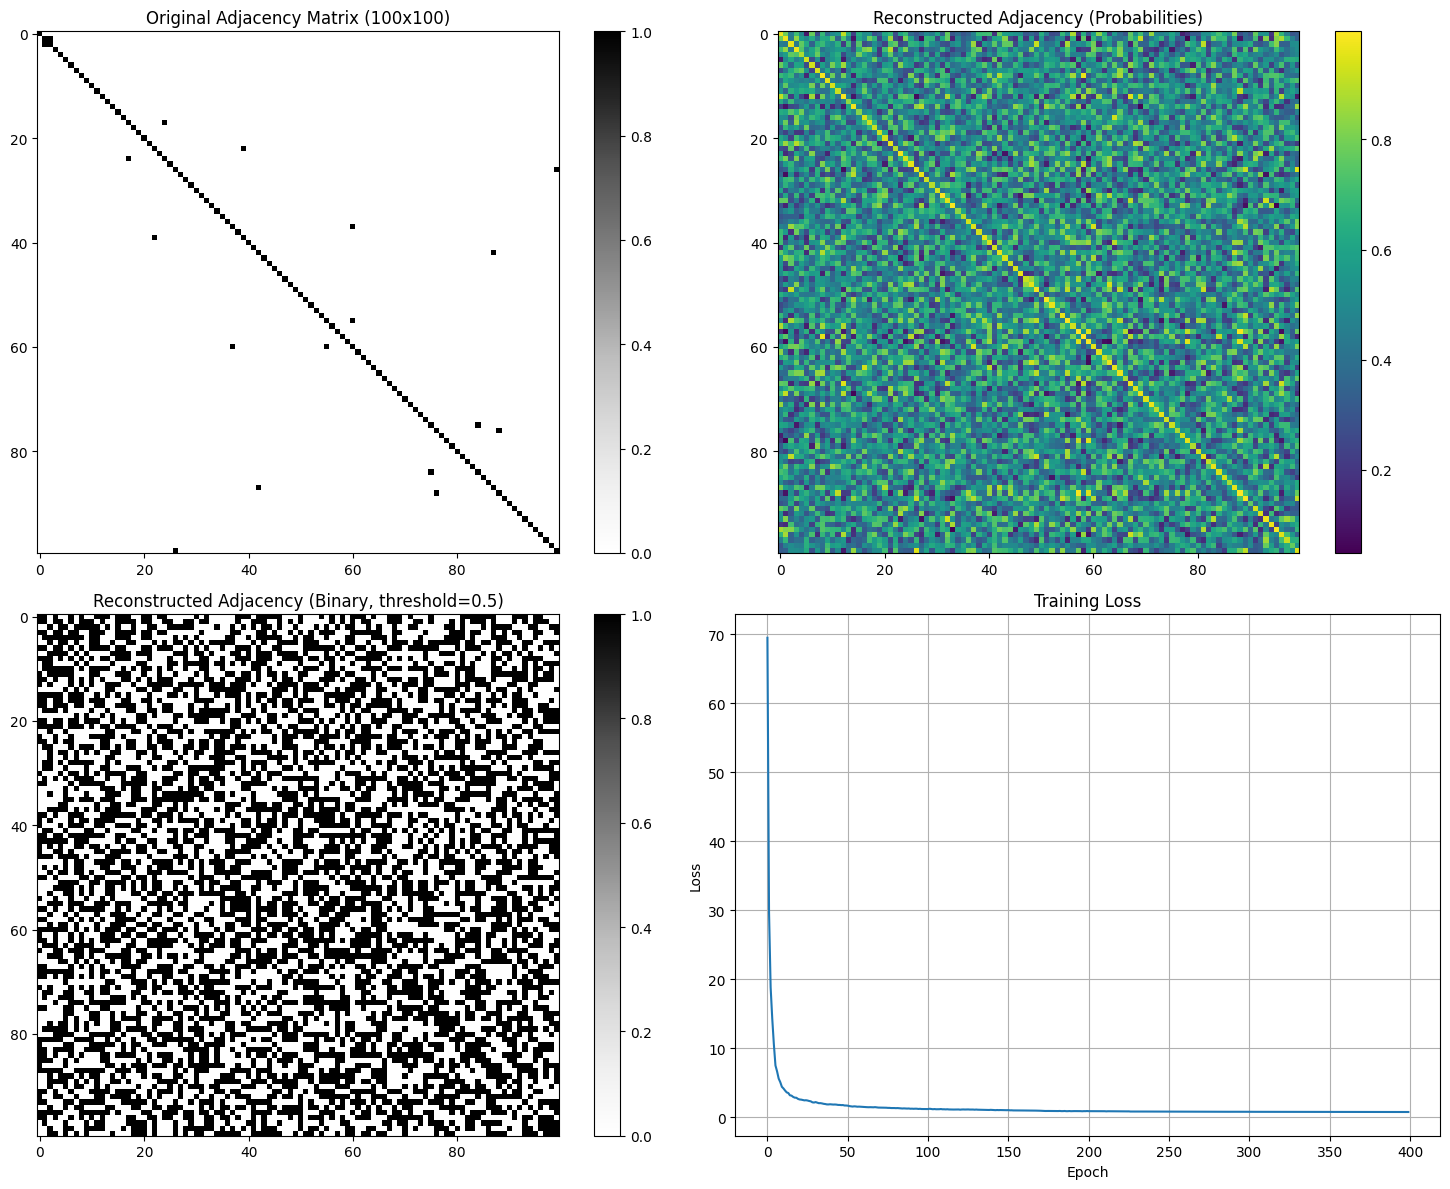

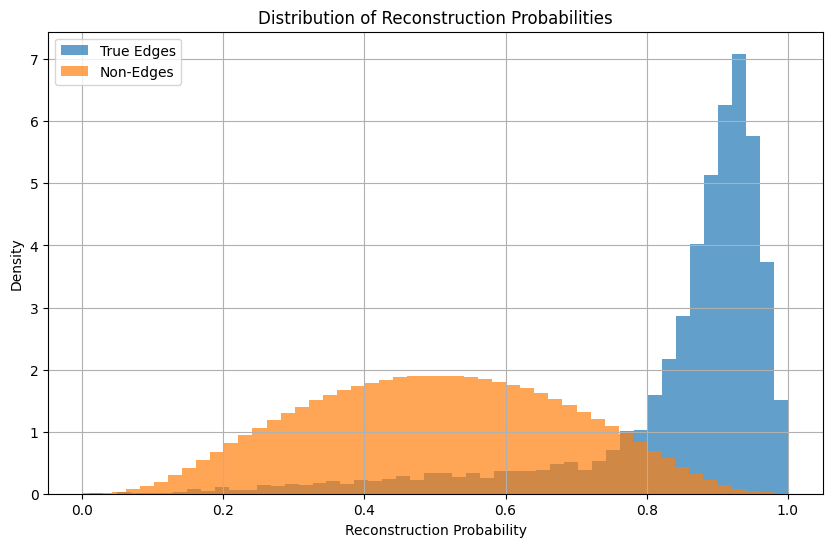

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit
from torch_geometric.utils import negative_sampling, add_self_loops
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

# Load and preprocess the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Add self-loops for better node representation
data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)

# Use RandomLinkSplit for link prediction
transform = RandomLinkSplit(is_undirected=True, split_labels=True, 
                           add_negative_train_samples=True, neg_sampling_ratio=1.0)
train_data, val_data, test_data = transform(data)

class ImprovedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.2):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Multiple GCN layers with residual connections
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        self.convs.append(GCNConv(hidden_channels, out_channels))
        
        # Batch normalization layers
        self.batch_norms = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
    def forward(self, x, edge_index):
        # First layer
        x = F.relu(self.batch_norms[0](self.convs[0](x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Middle layers with residual connections
        for i in range(1, self.num_layers - 1):
            residual = x
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x + residual)  # Residual connection
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer (no activation)
        x = self.convs[-1](x, edge_index)
        return x

class GraphAutoEncoder(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        
    def forward(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def decode(self, z, edge_index):
        # Improved decoder with sigmoid activation
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))
    
    def decode_all(self, z):
        # Decode all possible edges (for adjacency matrix reconstruction)
        prob_adj = torch.sigmoid(torch.matmul(z, z.T))
        return prob_adj

# Set device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
hidden_channels = 128
out_channels = 64
num_layers = 3
dropout = 0.2

# Initialize model
encoder = ImprovedGCNEncoder(dataset.num_features, hidden_channels, out_channels, 
                           num_layers, dropout)
model = GraphAutoEncoder(encoder).to(device)

# Optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# Move data to device
x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    
    # Encode
    z = model(x, edge_index)
    
    # Positive and negative edges
    pos_edge = train_data.pos_edge_label_index.to(device)
    neg_edge = train_data.neg_edge_label_index.to(device)
    
    # Decode
    pos_score = model.decode(z, pos_edge)
    neg_score = model.decode(z, neg_edge)
    
    # Improved loss function with label smoothing
    pos_loss = F.binary_cross_entropy(pos_score, torch.ones_like(pos_score) * 0.9)
    neg_loss = F.binary_cross_entropy(neg_score, torch.ones_like(neg_score) * 0.1)
    
    loss = pos_loss + neg_loss
    
    # Add L2 regularization on embeddings
    reg_loss = torch.norm(z, p=2, dim=1).mean() * 1e-4
    total_loss = loss + reg_loss
    
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    return total_loss.item()

def test(data_split):
    model.eval()
    with torch.no_grad():
        z = model(x, edge_index)
        
        pos_edge = data_split.pos_edge_label_index.to(device)
        neg_edge = data_split.neg_edge_label_index.to(device)
        
        pos_score = model.decode(z, pos_edge)
        neg_score = model.decode(z, neg_edge)
        
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = torch.cat([torch.ones(pos_score.size(0)), 
                           torch.zeros(neg_score.size(0))]).cpu().numpy()
        
        auc = roc_auc_score(labels, scores)
        ap = average_precision_score(labels, scores)
        
        return auc, ap

# Training loop
print("Starting training...")
train_losses = []
val_aucs = []

for epoch in range(1, 401):
    loss = train()
    train_losses.append(loss)
    scheduler.step()
    
    if epoch % 50 == 0:
        val_auc, val_ap = test(val_data)
        val_aucs.append(val_auc)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')

# Final test evaluation
test_auc, test_ap = test(test_data)
print(f'\nFinal Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

# ===== Adjacency Matrix Reconstruction =====
print("\nReconstructing adjacency matrix...")
model.eval()
with torch.no_grad():
    z = model(x, edge_index)
    adj_reconstructed = model.decode_all(z)

# Convert original adjacency matrix to dense form
original_adj = torch.zeros((data.num_nodes, data.num_nodes), device=device)
original_adj[data.edge_index[0], data.edge_index[1]] = 1.0

# Apply threshold to reconstructed adjacency matrix
threshold = 0.5
adj_reconstructed_binary = (adj_reconstructed > threshold).float()

# Calculate reconstruction accuracy
total_elements = original_adj.numel()
correct_predictions = (original_adj == adj_reconstructed_binary).sum().item()
accuracy = correct_predictions / total_elements

print(f"Adjacency Matrix Reconstruction Accuracy: {accuracy:.4f}")

# Calculate precision, recall for edge prediction
true_edges = original_adj.sum().item()
predicted_edges = adj_reconstructed_binary.sum().item()
true_positive = (original_adj * adj_reconstructed_binary).sum().item()

precision = true_positive / predicted_edges if predicted_edges > 0 else 0
recall = true_positive / true_edges if true_edges > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Edge Prediction - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1_score:.4f}")

# Visualize results
print("\nVisualizing results...")

# Show partial matrices (first 50x50 for better visibility)
print("\nOriginal Adjacency Matrix (partial 20x20):")
print(original_adj[:20, :20].cpu().numpy().astype(int))

print("\nReconstructed Adjacency Matrix (partial 20x20, probabilities):")
print(adj_reconstructed[:20, :20].cpu().numpy().round(3))

print("\nReconstructed Adjacency Matrix (partial 20x20, binary with threshold=0.5):")
print(adj_reconstructed_binary[:20, :20].cpu().numpy().astype(int))

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original adjacency matrix
im1 = axes[0, 0].imshow(original_adj[:100, :100].cpu().numpy(), cmap='Greys', interpolation='none')
axes[0, 0].set_title("Original Adjacency Matrix (100x100)")
plt.colorbar(im1, ax=axes[0, 0])

# Reconstructed adjacency matrix (probabilities)
im2 = axes[0, 1].imshow(adj_reconstructed[:100, :100].cpu().numpy(), cmap='viridis', interpolation='none')
axes[0, 1].set_title("Reconstructed Adjacency (Probabilities)")
plt.colorbar(im2, ax=axes[0, 1])

# Reconstructed adjacency matrix (binary)
im3 = axes[1, 0].imshow(adj_reconstructed_binary[:100, :100].cpu().numpy(), cmap='Greys', interpolation='none')
axes[1, 0].set_title("Reconstructed Adjacency (Binary, threshold=0.5)")
plt.colorbar(im3, ax=axes[1, 0])

# Training loss
axes[1, 1].plot(train_losses)
axes[1, 1].set_title("Training Loss")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Additional analysis: Edge probability distribution
edge_probs = adj_reconstructed[original_adj == 1].cpu().numpy()
non_edge_probs = adj_reconstructed[original_adj == 0].cpu().numpy()

plt.figure(figsize=(10, 6))
plt.hist(edge_probs, bins=50, alpha=0.7, label='True Edges', density=True)
plt.hist(non_edge_probs, bins=50, alpha=0.7, label='Non-Edges', density=True)
plt.xlabel('Reconstruction Probability')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Probabilities')
plt.legend()
plt.grid(True)
plt.show()

Epoch 10, Loss: 1.3158
Epoch 20, Loss: 0.9708
Epoch 30, Loss: 0.7824
Epoch 40, Loss: 0.6238
Epoch 50, Loss: 0.4525
Epoch 60, Loss: 0.3085
Epoch 70, Loss: 0.1882
Epoch 80, Loss: 0.0978
Epoch 90, Loss: 0.0462
Epoch 100, Loss: 0.0197
Epoch 110, Loss: 0.0086
Epoch 120, Loss: 0.0042
Epoch 130, Loss: 0.0024
Epoch 140, Loss: 0.0016
Epoch 150, Loss: 0.0011
Epoch 160, Loss: 0.0009
Epoch 170, Loss: 0.0007
Epoch 180, Loss: 0.0006
Epoch 190, Loss: 0.0006
Epoch 200, Loss: 0.0005
Epoch 210, Loss: 0.0004
Epoch 220, Loss: 0.0004
Epoch 230, Loss: 0.0003
Epoch 240, Loss: 0.0003
Epoch 250, Loss: 0.0003
Epoch 260, Loss: 0.0003
Epoch 270, Loss: 0.0002
Epoch 280, Loss: 0.0002
Epoch 290, Loss: 0.0002
Epoch 300, Loss: 0.0002
Epoch 310, Loss: 0.0002
Epoch 320, Loss: 0.0002
Epoch 330, Loss: 0.0002
Epoch 340, Loss: 0.0001
Epoch 350, Loss: 0.0001
Epoch 360, Loss: 0.0001
Epoch 370, Loss: 0.0001
Epoch 380, Loss: 0.0001
Epoch 390, Loss: 0.0001
Epoch 400, Loss: 0.0001
Epoch 410, Loss: 0.0001
Epoch 420, Loss: 0.0001
E

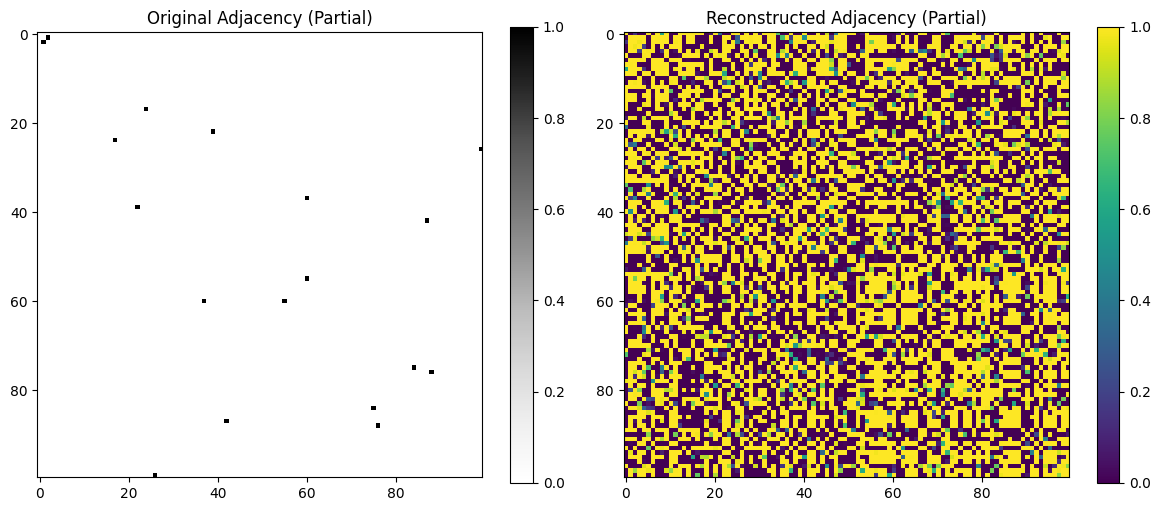

In [33]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit
import matplotlib.pyplot as plt

# Load and preprocess the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Use RandomLinkSplit to split the graph for link prediction
transform = RandomLinkSplit(is_undirected=True, split_labels=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

# Define the GCN-based encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 5 * out_channels)
        self.conv2 = GCNConv(5* out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Set device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNEncoder(dataset.num_features, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Move data to device
x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    z = model(x, edge_index)

    pos_edge = train_data.pos_edge_label_index.to(device)
    neg_edge = train_data.neg_edge_label_index.to(device)

    pos_score = torch.sigmoid((z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1))
    neg_score = torch.sigmoid((z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1))

    pos_loss = -torch.log(pos_score + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_score + 1e-15).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()
    return loss.item()

# Run training
for epoch in range(1, 501):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# ===== After training, show reconstructed adjacency matrix =====
model.eval()
with torch.no_grad():
    z = model(x, edge_index)  # Node embeddings
    adj_reconstructed = torch.sigmoid(torch.matmul(z, z.T))  # Reconstructed adjacency matrix

# Convert original adjacency matrix to dense form (for comparison)
original_adj = torch.zeros((data.num_nodes, data.num_nodes), device=device)
original_adj[data.edge_index[0], data.edge_index[1]] = 1.0

# Show part of the matrices (e.g., first 10x10 block)
print("\nOriginal Adjacency Matrix (partial):")
print(original_adj[:10, :10].cpu().numpy().round(2))

print("\nReconstructed Adjacency Matrix (partial):")
print(adj_reconstructed[:10, :10].cpu().numpy().round(2))


# Move matrices to CPU for visualization
orig_adj_np = original_adj[:100, :100].cpu().numpy()  # smaller slice for visibility
recon_adj_np = adj_reconstructed[:100, :100].cpu().numpy()

# Plot side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_adj_np, cmap='Greys', interpolation='none')
plt.title("Original Adjacency (Partial)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(recon_adj_np, cmap='viridis', interpolation='none')
plt.title("Reconstructed Adjacency (Partial)")
plt.colorbar()

plt.tight_layout()
plt.show()

Epoch 10, Loss: 0.6812
Epoch 20, Loss: 0.6454
Epoch 30, Loss: 0.5988
Epoch 40, Loss: 0.5887
Epoch 50, Loss: 0.5522
Epoch 60, Loss: 0.5379
Epoch 70, Loss: 0.5330
Epoch 80, Loss: 0.5323
Epoch 90, Loss: 0.5228
Epoch 100, Loss: 0.5273
Epoch 110, Loss: 0.5181
Epoch 120, Loss: 0.5184
Epoch 130, Loss: 0.5161
Epoch 140, Loss: 0.5146
Epoch 150, Loss: 0.5175
Epoch 160, Loss: 0.5115
Epoch 170, Loss: 0.5088
Epoch 180, Loss: 0.5106
Epoch 190, Loss: 0.5227
Epoch 200, Loss: 0.5094


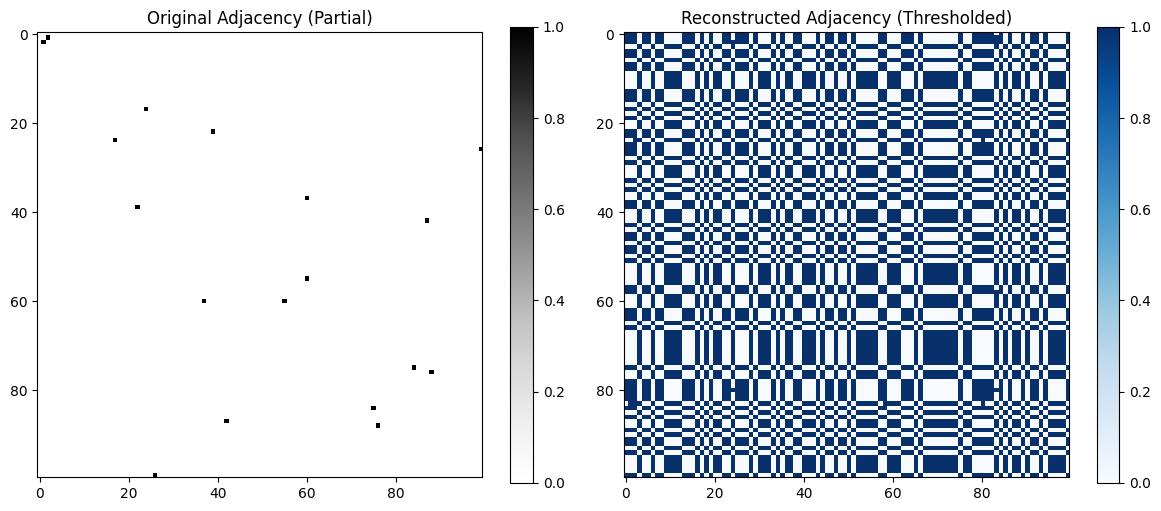

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit
import matplotlib.pyplot as plt

# Load and preprocess the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Use RandomLinkSplit for train/val/test splits
transform = RandomLinkSplit(is_undirected=True, split_labels=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

# Define the GCN-based encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 5 * out_channels)
        self.conv2 = GCNConv(5 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(F.relu(self.conv1(x, edge_index)), p=0.5, training=self.training)
        return self.conv2(x, edge_index)

# Set device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNEncoder(dataset.num_features, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Move data to device
x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

# Training function with balanced BCE loss
def train():
    model.train()
    optimizer.zero_grad()
    z = model(x, edge_index)

    pos_edge = train_data.pos_edge_label_index.to(device)
    neg_edge = train_data.neg_edge_label_index.to(device)

    # Combine edges and labels
    edge = torch.cat([pos_edge, neg_edge], dim=1)
    labels = torch.cat([
        torch.ones(pos_edge.size(1), device=device),
        torch.zeros(neg_edge.size(1), device=device)
    ])

    scores = torch.sigmoid((z[edge[0]] * z[edge[1]]).sum(dim=1))
    loss = F.binary_cross_entropy(scores, labels)

    loss.backward()
    optimizer.step()
    return loss.item()

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# ===== Visualization after training =====
model.eval()
with torch.no_grad():
    z = model(x, edge_index)
    adj_reconstructed = torch.sigmoid(torch.matmul(z, z.T))
    adj_binary = (adj_reconstructed > 0.5).float()

# Original adjacency matrix (symmetric)
original_adj = torch.zeros((data.num_nodes, data.num_nodes), device=device)
original_adj[data.edge_index[0], data.edge_index[1]] = 1.0
original_adj[data.edge_index[1], data.edge_index[0]] = 1.0  # make symmetric

# Plot first 100x100 block
orig = original_adj[:100, :100].cpu().numpy()
recon = adj_binary[:100, :100].cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig, cmap='Greys', interpolation='none')
plt.title("Original Adjacency (Partial)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(recon, cmap='Blues', interpolation='none')
plt.title("Reconstructed Adjacency (Thresholded)")
plt.colorbar()

plt.tight_layout()
plt.show()


Epoch 20, Loss: 0.6594
Epoch 40, Loss: 0.6302
Epoch 60, Loss: 0.6178
Epoch 80, Loss: 0.6141
Epoch 100, Loss: 0.6105
Epoch 120, Loss: 0.6077
Epoch 140, Loss: 0.6059
Epoch 160, Loss: 0.6030
Epoch 180, Loss: 0.6021
Epoch 200, Loss: 0.6014
Epoch 220, Loss: 0.6010
Epoch 240, Loss: 0.6006
Epoch 260, Loss: 0.6003
Epoch 280, Loss: 0.5999
Epoch 300, Loss: 0.5990
Epoch 320, Loss: 0.5982
Epoch 340, Loss: 0.5976
Epoch 360, Loss: 0.5969
Epoch 380, Loss: 0.5959
Epoch 400, Loss: 0.5950
Epoch 420, Loss: 0.5941
Epoch 440, Loss: 0.5932
Epoch 460, Loss: 0.5929
Epoch 480, Loss: 0.5923
Epoch 500, Loss: 0.5920


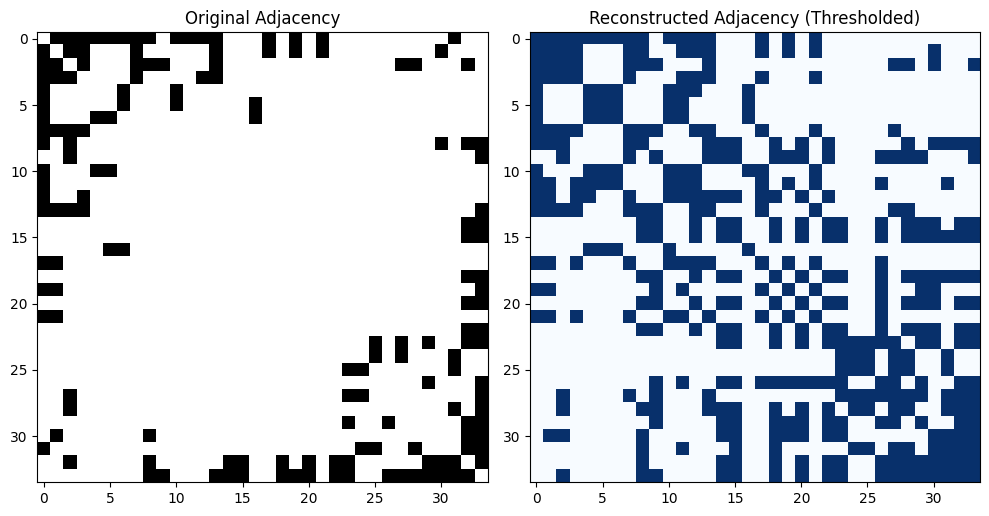

In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# Define a Graph Autoencoder (GAE)
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Instantiate the model and optimizer
in_channels = dataset.num_features
hidden_dim = 16
encoder = GCNEncoder(in_channels, hidden_dim)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

# Training loop
def train():
    encoder.train()
    optimizer.zero_grad()
    z = encoder(data.x, data.edge_index)

    # Positive edges
    adj_orig = to_dense_adj(data.edge_index)[0]
    
    # Decoder using inner product
    adj_recon = torch.sigmoid(z @ z.t())
    
    # BCE Loss
    loss = F.binary_cross_entropy(adj_recon, adj_orig)
    loss.backward()
    optimizer.step()
    return loss.item(), adj_orig.detach(), adj_recon.detach()

# Train for a few epochs
for epoch in range(1, 501):
    loss, adj_orig, adj_recon = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Threshold reconstructed adjacency matrix for visualization
adj_recon_thresh = (adj_recon > 0.5).float()

# Plot original and reconstructed adjacency matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(adj_orig.numpy(), cmap='Greys')
axes[0].set_title('Original Adjacency')

axes[1].imshow(adj_recon_thresh.numpy(), cmap='Blues')
axes[1].set_title('Reconstructed Adjacency (Thresholded)')

plt.tight_layout()
plt.show()


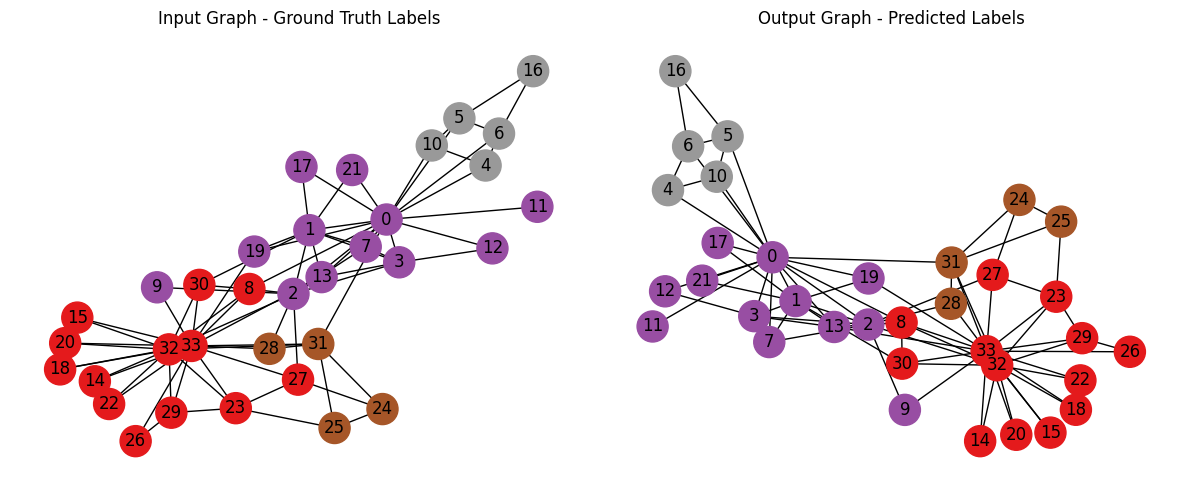

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Load dataset
dataset = KarateClub()
data = dataset[0]

# GCN Model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train the model (quick training for demo)
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

# Evaluate
model.eval()
out = model(data)
pred = out.argmax(dim=1)

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Plot input graph (ground truth labels)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
nx.draw(G, with_labels=True, node_color=data.y.numpy(), cmap=plt.cm.Set1, node_size=500)
plt.title("Input Graph - Ground Truth Labels")

# Plot output graph (predicted labels)
plt.subplot(1, 2, 2)
nx.draw(G, with_labels=True, node_color=pred.numpy(), cmap=plt.cm.Set1, node_size=500)
plt.title("Output Graph - Predicted Labels")

plt.tight_layout()
plt.show()


Epoch 1, Train Loss: 0.6931, Val Loss: 0.6881
Epoch 20, Train Loss: 0.6136, Val Loss: 0.6323
Epoch 40, Train Loss: 0.4724, Val Loss: 0.5822
Epoch 60, Train Loss: 0.3791, Val Loss: 0.6024
Epoch 80, Train Loss: 0.2987, Val Loss: 0.6938
Epoch 100, Train Loss: 0.2237, Val Loss: 0.8654
Epoch 120, Train Loss: 0.1554, Val Loss: 1.1859
Epoch 140, Train Loss: 0.1001, Val Loss: 1.6586
Epoch 160, Train Loss: 0.0617, Val Loss: 2.2511
Epoch 180, Train Loss: 0.0356, Val Loss: 2.9804
Epoch 200, Train Loss: 0.0195, Val Loss: 3.7578

Test Loss: 3.5775


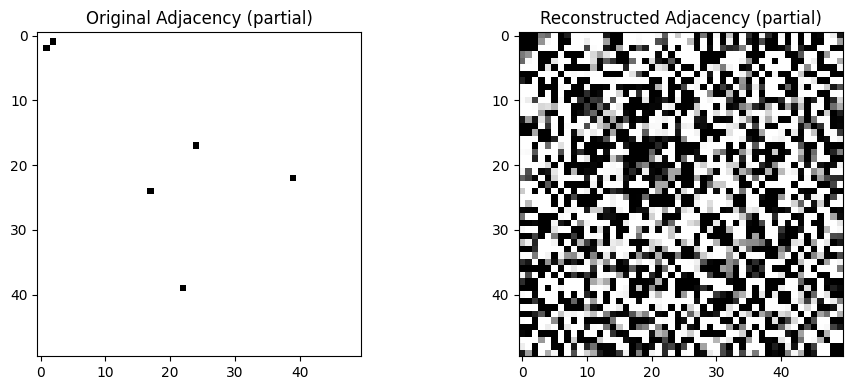

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit

# Load dataset and normalize features
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=NormalizeFeatures())
data = dataset[0]

transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    split_labels=True
)

train_data, val_data, test_data = transform(data)

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class GAEModel(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)

    def decode_all(self, z):
        sim = torch.sigmoid(torch.matmul(z, z.t()))
        return sim

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

encoder = GCNEncoder(dataset.num_features, out_channels=32)
model = GAEModel(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    pos_pred = model.decode(z, train_data.pos_edge_label_index)
    neg_pred = model.decode(z, train_data.neg_edge_label_index)

    pos_label = torch.ones(pos_pred.size(0), device=pos_pred.device)
    neg_label = torch.zeros(neg_pred.size(0), device=neg_pred.device)

    pred = torch.cat([pos_pred, neg_pred], dim=0)
    label = torch.cat([pos_label, neg_label], dim=0)

    loss = F.binary_cross_entropy_with_logits(pred, label)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data_split):
    model.eval()
    z = model.encode(data_split.x, data_split.edge_index)
    pos_pred = model.decode(z, data_split.pos_edge_label_index)
    neg_pred = model.decode(z, data_split.neg_edge_label_index)
    pos_label = torch.ones(pos_pred.size(0), device=pos_pred.device)
    neg_label = torch.zeros(neg_pred.size(0), device=neg_pred.device)
    pred = torch.cat([pos_pred, neg_pred], dim=0)
    label = torch.cat([pos_label, neg_label], dim=0)
    return F.binary_cross_entropy_with_logits(pred, label).item()

# Train the model
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0 or epoch == 1:
        val_loss = test(val_data)
        print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

test_loss = test(test_data)
print(f"\nTest Loss: {test_loss:.4f}")

# ==== Visualize original and reconstructed adjacency matrices ====
@torch.no_grad()
def visualize_adjacency_matrices():
    model.eval()
    z = model.encode(data.x, data.edge_index)  # full graph encoding
    adj_reconstructed = model.decode_all(z).cpu()

    # Original adjacency matrix (sparse to dense)
    num_nodes = data.num_nodes
    adj_original = torch.zeros((num_nodes, num_nodes))
    adj_original[data.edge_index[0], data.edge_index[1]] = 1
    adj_original = adj_original.cpu()

    # Visualize partial matrices (first 50 nodes for clarity)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(adj_original[:50, :50], cmap='gray_r')
    axs[0].set_title("Original Adjacency (partial)")

    axs[1].imshow(adj_reconstructed[:50, :50], cmap='gray_r')
    axs[1].set_title("Reconstructed Adjacency (partial)")

    plt.tight_layout()
    plt.show()

visualize_adjacency_matrices()


## Graph Variational Autoencoder (GVAE)

### Introduction

Graph Variational Autoencoders (GVAE) combine the power of variational autoencoders with graph neural networks to learn **probabilistic latent representations** of nodes in graph-structured data. Like traditional VAEs, GVAEs encode inputs into a distribution (typically Gaussian) rather than a deterministic point, which allows for uncertainty modeling and generative capabilities.

They are particularly effective for:
- **Link prediction**
- **Uncertainty modeling** in node embeddings
- **Robust representation learning** under noise

---

### Mathematical Formulation

Let:
- $ A \in \mathbb{R}^{n \times n} $: adjacency matrix
- $ X \in \mathbb{R}^{n \times d} $: node feature matrix

#### **Encoder**  
The encoder learns parameters of a Gaussian distribution:

$$
\mu = \text{GNN}_\mu(X, A), \quad \log \sigma^2 = \text{GNN}_\sigma(X, A)
$$

Sample latent embeddings via the **reparameterization trick**:

$$
Z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

#### **Decoder**  
The decoder reconstructs the graph structure:

$$
\hat{A} = \sigma(ZZ^T)
$$

#### **Loss Function**  
The objective combines a reconstruction loss with a KL divergence regularization:

$$
\mathcal{L}_{\text{GVAE}} = \mathbb{E}_{q(Z|X,A)}[\log p(A|Z)] - \text{KL}(q(Z|X,A) \| p(Z))
$$

---

### Implementation with PyTorch Geometric




Epoch 10, Loss: 5.9581
Epoch 20, Loss: 6.1213
Epoch 30, Loss: 6.0866
Epoch 40, Loss: 5.9531
Epoch 50, Loss: 5.8172
Epoch 60, Loss: 5.8643
Epoch 70, Loss: 5.9574
Epoch 80, Loss: 6.0560
Epoch 90, Loss: 6.0929
Epoch 100, Loss: 5.8261
Epoch 110, Loss: 6.0114
Epoch 120, Loss: 5.8629
Epoch 130, Loss: 5.9690
Epoch 140, Loss: 5.8276
Epoch 150, Loss: 5.9307
Epoch 160, Loss: 5.9110
Epoch 170, Loss: 5.7449
Epoch 180, Loss: 5.7574
Epoch 190, Loss: 5.8821
Epoch 200, Loss: 5.7373
Epoch 10, Loss: 5.9005
Epoch 20, Loss: 5.8312
Epoch 30, Loss: 5.9049
Epoch 40, Loss: 5.8705
Epoch 50, Loss: 5.9588
Epoch 60, Loss: 5.8244
Epoch 70, Loss: 6.0323
Epoch 80, Loss: 5.7924
Epoch 90, Loss: 6.0420
Epoch 100, Loss: 5.6374
Epoch 110, Loss: 5.8845
Epoch 120, Loss: 5.7895
Epoch 130, Loss: 6.0201
Epoch 140, Loss: 5.6767
Epoch 150, Loss: 5.8892
Epoch 160, Loss: 5.9167
Epoch 170, Loss: 5.8043
Epoch 180, Loss: 5.7969
Epoch 190, Loss: 5.6548
Epoch 200, Loss: 5.6711


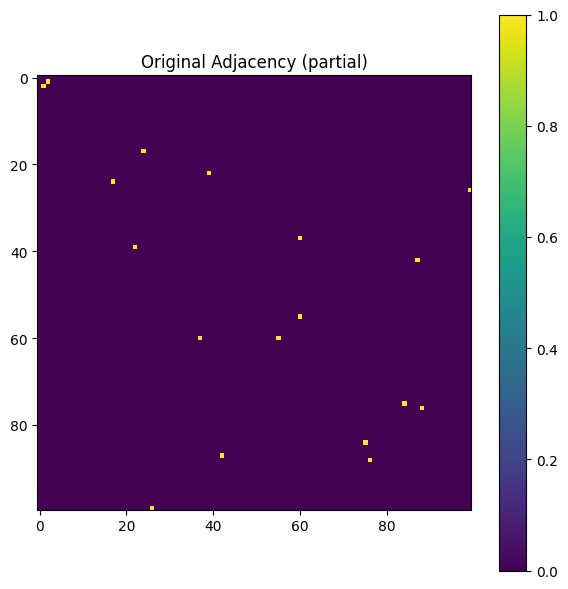

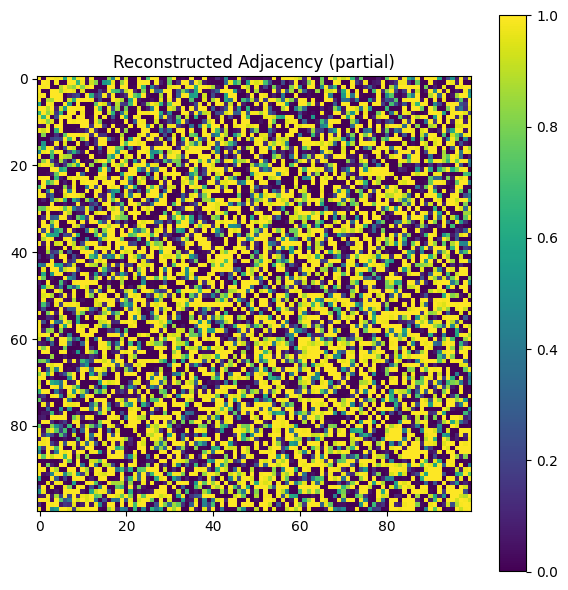

In [38]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit

# Load and preprocess dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Random link split
transform = RandomLinkSplit(is_undirected=True, split_labels=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

# GVAE Encoder
class GVAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gc1 = GCNConv(in_channels, 2 * out_channels)
        self.gc_mu = GCNConv(2 * out_channels, out_channels)
        self.gc_logvar = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        h = F.relu(self.gc1(x, edge_index))
        mu = self.gc_mu(h, edge_index)
        logvar = self.gc_logvar(h, edge_index)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GVAEEncoder(dataset.num_features, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

# Loss: binary cross-entropy + KL divergence
def loss_fn(z, pos_edge, neg_edge, mu, logvar):
    pos_score = torch.sigmoid((z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1))
    neg_score = torch.sigmoid((z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1))

    pos_loss = -torch.log(pos_score + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_score + 1e-15).mean()
    recon_loss = pos_loss + neg_loss

    kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_div

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    mu, logvar = model(x, edge_index)
    z = reparameterize(mu, logvar)

    pos_edge = train_data.pos_edge_label_index.to(device)
    neg_edge = train_data.neg_edge_label_index.to(device)

    loss = loss_fn(z, pos_edge, neg_edge, mu, logvar)
    loss.backward()
    optimizer.step()
    return loss.item()

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


import matplotlib.pyplot as plt
import numpy as np

# Function to plot adjacency matrix
def plot_adj_matrix(matrix, title, vmax=1.0):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='viridis', vmax=vmax)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# ======= Reconstruction after training =======
model.eval()
with torch.no_grad():
    mu, logvar = model(x, edge_index)
    z = reparameterize(mu, logvar)
    adj_reconstructed = torch.sigmoid(torch.matmul(z, z.t())).cpu().numpy()

# ======= Original adjacency (for comparison) =======
original_adj = torch.zeros((data.num_nodes, data.num_nodes))
original_adj[data.edge_index[0], data.edge_index[1]] = 1
original_adj = original_adj.cpu().numpy()

# ======= Plot original and reconstructed adjacency =======
plot_adj_matrix(original_adj[:100, :100], "Original Adjacency (partial)")
plot_adj_matrix(adj_reconstructed[:100, :100], "Reconstructed Adjacency (partial)")


Epoch 20, Loss: 5.0700
Epoch 40, Loss: 5.0512
Epoch 60, Loss: 4.8297
Epoch 80, Loss: 5.1686
Epoch 100, Loss: 5.2693
Epoch 120, Loss: 5.0677
Epoch 140, Loss: 5.3333
Epoch 160, Loss: 5.5195
Epoch 180, Loss: 5.1163
Epoch 200, Loss: 4.8946


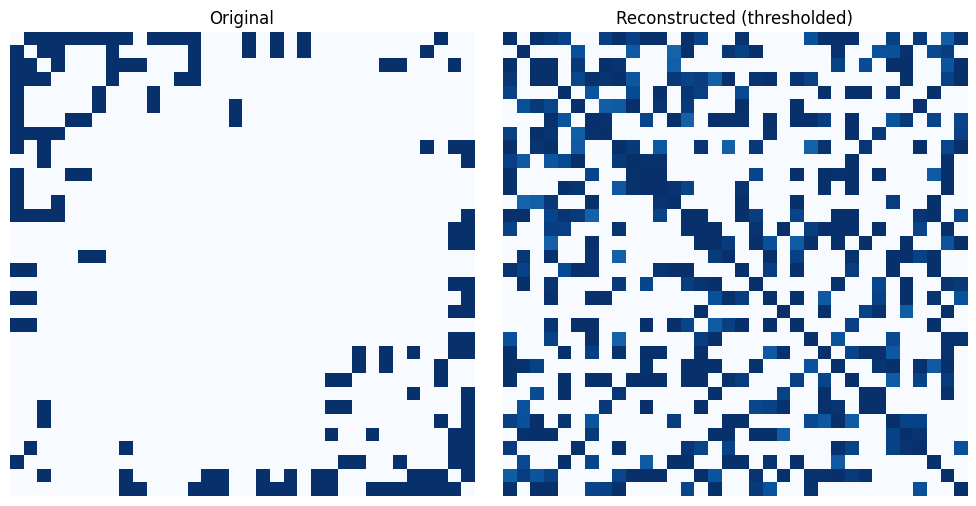

In [44]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx, to_dense_adj
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx

# === ساخت گراف با NetworkX ===
G = nx.karate_club_graph()  # گراف ساده ولی مشهور
data = from_networkx(G)
data.x = torch.eye(data.num_nodes)  # ویژگی اولیه: بردار one-hot

# === تعریف GVAE ===
class GVAEEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gc1 = GCNConv(in_channels, 2 * out_channels)
        self.gc_mu = GCNConv(2 * out_channels, out_channels)
        self.gc_logvar = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        h = F.relu(self.gc1(x, edge_index))
        mu = self.gc_mu(h, edge_index)
        logvar = self.gc_logvar(h, edge_index)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class GVAE(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def encode(self, x, edge_index):
        mu, logvar = self.encoder(x, edge_index)
        z = reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        return torch.sigmoid(torch.matmul(z, z.t()))

# === تنظیمات اولیه ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GVAE(GVAEEncoder(data.num_nodes, 32)).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# === تابع خطا ===
def loss_fn(adj_orig, adj_recon, mu, logvar):
    recon_loss = F.binary_cross_entropy(adj_recon, adj_orig)
    kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_div

# === آموزش ===
adj_orig = to_dense_adj(data.edge_index)[0]
adj_orig = (adj_orig + adj_orig.t()).clamp(0, 1)  # undirected
adj_orig = adj_orig.to(device)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z, mu, logvar = model.encode(data.x, data.edge_index)
    adj_recon = model.decode(z)
    loss = loss_fn(adj_orig, adj_recon, mu, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# === نمایش نتایج ===
def plot_adjs_side_by_side(adj1, adj2, titles=["Original", "Reconstructed"]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(adj1.cpu().detach().numpy(), cmap="Blues")
    axs[0].set_title(titles[0])

    axs[1].imshow(adj2.cpu().detach().numpy(), cmap="Blues")
    axs[1].set_title(titles[1])

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()



# ماتریس بازسازی شده را محاسبه می‌کنیم
adj_recon = model.decode(z)

# مقادیر کمتر از 1 را صفر می‌کنیم
adj_recon_thresholded = adj_recon.clone()
adj_recon_thresholded[adj_recon_thresholded < 0.8] = 0

# نمایش ماتریس‌ها
plot_adjs_side_by_side(adj_orig, adj_recon_thresholded, titles=["Original", "Reconstructed (thresholded)"])

